In [1]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 57.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitli

In [2]:
!pip install pytesseract

In [3]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 21.7 MB/s eta 0:00:00


In [4]:
import cv2
import numpy as np
import pytesseract
import matplotlib.pyplot as plt
import pandas as pd
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # or ":16:8"
import torch

import torch
import random
from transformers import ViTFeatureExtractor, ViTModel
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import pytorch_lightning as pl
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import itertools
import optuna
import json
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.decomposition import PCA

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#1. Multimodal Time Series Model using Transformer and GRU

In [6]:

import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # or ":16:8"
torch.use_deterministic_algorithms(False)
import torch

import json
import pandas as pd
import numpy as np

from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import optuna

numerical_features = ["Ice Coverage (%)", "Retreat Area (Since 1979) (%)"]
vit_features = [f"ViT_Feature_{i}" for i in range(768)]
target_column = ["Retreat Area (Yearly) (%)"]

# Load CSV
df = pd.read_csv("/content/drive/MyDrive/dip_project/ice_extent_full_dataset.csv")
df = df.sort_values(["Year", "Image"])

# Create sequences using a sliding window approach.
sequence_length = 3

def create_sequences(df, sequence_length, numerical_features, vit_features, target_column):
    sequences_num = []
    sequences_vit = []
    targets = []
    years = []
    for i in range(len(df) - sequence_length + 1):
        seq_num = df.iloc[i:i+sequence_length][numerical_features].values
        seq_vit = df.iloc[i:i+sequence_length][vit_features].values
        target = df.iloc[i+sequence_length - 1][target_column].values
        year = df.iloc[i+sequence_length - 1]["Year"]
        sequences_num.append(seq_num)
        sequences_vit.append(seq_vit)
        targets.append(target)
        years.append(year)
    return np.array(sequences_num), np.array(sequences_vit), np.array(targets), np.array(years)

seq_num, seq_vit, targets, years = create_sequences(df, sequence_length, numerical_features, vit_features, target_column)

# Split sequences into train, validation, and test sets
n = len(seq_num)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

train_num, val_num, test_num = seq_num[:train_end], seq_num[train_end:val_end], seq_num[val_end:]
train_vit, val_vit, test_vit = seq_vit[:train_end], seq_vit[train_end:val_end], seq_vit[val_end:]
y_train, y_val, y_test = targets[:train_end], targets[train_end:val_end], targets[val_end:]
year_train, year_val, year_test = years[:train_end], years[train_end:val_end], years[val_end:]

# Normalize numerical features
scaler_num = StandardScaler()
scaler_target = StandardScaler()

train_num_flat = train_num.reshape(-1, len(numerical_features))
scaler_num.fit(train_num_flat)
train_num = scaler_num.transform(train_num_flat).reshape(train_num.shape)
val_num_flat = val_num.reshape(-1, len(numerical_features))
val_num = scaler_num.transform(val_num_flat).reshape(val_num.shape)
test_num_flat = test_num.reshape(-1, len(numerical_features))
test_num = scaler_num.transform(test_num_flat).reshape(test_num.shape)

y_train = scaler_target.fit_transform(y_train.reshape(-1,1)).flatten()
y_val = scaler_target.transform(y_val.reshape(-1,1)).flatten()
y_test = scaler_target.transform(y_test.reshape(-1,1)).flatten()


X_train_num = torch.tensor(train_num, dtype=torch.float32)
X_train_vit = torch.tensor(train_vit, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_val_num = torch.tensor(val_num, dtype=torch.float32)
X_val_vit = torch.tensor(val_vit, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

X_test_num = torch.tensor(test_num, dtype=torch.float32)
X_test_vit = torch.tensor(test_vit, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Datasets and DataLoaders
train_dataset = TensorDataset(X_train_num, X_train_vit, y_train)
val_dataset = TensorDataset(X_val_num, X_val_vit, y_val)
test_dataset = TensorDataset(X_test_num, X_test_vit, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Train sequences: {len(train_dataset)}, Val sequences: {len(val_dataset)}, Test sequences: {len(test_dataset)}")

# Define the Multimodal Time Series Model using GRU

from torch.nn import TransformerEncoder, TransformerEncoderLayer

class CombinedTransformerGRUModel(pl.LightningModule):
    def __init__(self, num_feature_dim, d_model=128, fusion_output_dim=256, transformer_layers=1,
                 gru_hidden_size=128, gru_layers=1, dropout=0.1, learning_rate=1e-4):

        super().__init__()
        self.save_hyperparameters()

        # Encoders for each modality
        self.encoder_num = nn.Linear(num_feature_dim, d_model)
        self.encoder_vit = nn.Linear(768, d_model)

        # Fusion layer
        self.fusion_layer = nn.Linear(2 * d_model, fusion_output_dim)

        # Transformer Encoder
        encoder_layer = TransformerEncoderLayer(d_model=fusion_output_dim,
                                                nhead=4,
                                                dropout=dropout,
                                                batch_first=True)
        self.transformer = TransformerEncoder(encoder_layer, num_layers=transformer_layers)

        # GRU
        self.gru = nn.GRU(input_size=fusion_output_dim,
                          hidden_size=gru_hidden_size,
                          num_layers=gru_layers,
                          batch_first=True,
                          dropout=dropout if gru_layers > 1 else 0)

        # Output layer
        self.output_layer = nn.Linear(gru_hidden_size, 1)

        # Loss and learning rate configuration.
        self.criterion = nn.MSELoss()
        self.learning_rate = learning_rate

    def forward(self, x_num, x_vit):

        x_num_enc = self.encoder_num(x_num)
        x_vit_enc = self.encoder_vit(x_vit)

        # Fuse the two modalities by concatenating
        x_fused = torch.cat([x_num_enc, x_vit_enc], dim=2)
        fused = self.fusion_layer(x_fused)

        # Transformer Encoder
        transformed = self.transformer(fused)

        # refined sequence through the GRU
        _, h_n = self.gru(transformed)
        final_hidden = h_n[-1]

        # predict using final hidden state.
        output = self.output_layer(final_hidden).squeeze()
        return output

    def training_step(self, batch, batch_idx):
        x_num, x_vit, y = batch
        y_pred = self(x_num, x_vit)
        loss = self.criterion(y_pred, y)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x_num, x_vit, y = batch
        y_pred = self(x_num, x_vit)
        loss = self.criterion(y_pred, y)
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=3, factor=0.5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}


# Hyperparameter Tuning with Optuna and CSV Logging

def objective(trial):

    d_model = trial.suggest_categorical("d_model", [64, 128, 256])
    fusion_output_dim = trial.suggest_categorical("fusion_output_dim", [128, 256, 512])
    gru_hidden_size = trial.suggest_categorical("gru_hidden_size", [64, 128])
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-3)
    transformer_layers = trial.suggest_int("transformer_layers", 1, 3)

    model = CombinedTransformerGRUModel(
        num_feature_dim=len(numerical_features),
        d_model=d_model,
        fusion_output_dim=fusion_output_dim,
        transformer_layers=transformer_layers,
        gru_hidden_size=gru_hidden_size,
        gru_layers=1,
        dropout=dropout,
        learning_rate=learning_rate
    )

    # CSV Logger to log epoch metrics in a trial-specific directory
    csv_logger = CSVLogger(save_dir="logs", name=f"trial_{trial.number}")

    # checkpoint callback to monitor validation loss
    checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1)

    trainer = pl.Trainer(
        max_epochs=50,
        logger=csv_logger,
        callbacks=[checkpoint_callback],
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1,
        log_every_n_steps=10,
        enable_progress_bar=False,
        deterministic=False
    )

    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

    best_val_loss = checkpoint_callback.best_model_score.item() if checkpoint_callback.best_model_score is not None else float('inf')
    return best_val_loss

# hyperparameter tuning study with optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
print("Best Hyperparameters:", study.best_params)

# best hyperparameters
with open("/content/drive/MyDrive/dip_project/multimodal/best_params.json", "w") as f:
    json.dump(study.best_params, f)

#Final Model Training with Best Hyperparameters and CSV Logger
with open("/content/drive/MyDrive/dip_project/multimodal/best_params.json", "r") as f:
    best_params = json.load(f)

final_model = CombinedTransformerGRUModel(
    num_feature_dim=len(numerical_features),
    d_model=best_params["d_model"],
    fusion_output_dim=best_params["fusion_output_dim"],
    gru_hidden_size=best_params["gru_hidden_size"],
    gru_layers=1,
    dropout=best_params["dropout"],
    learning_rate=best_params["learning_rate"]
)


final_csv_logger = CSVLogger(save_dir="/content/drive/MyDrive/dip_project/log", name="final_model")

checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1)

trainer = pl.Trainer(
    max_epochs=50,
    logger=final_csv_logger,
    callbacks=[checkpoint_callback],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    log_every_n_steps=10,
    enable_progress_bar=True,
)

trainer.fit(final_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

print(f"Final training metrics are logged at: {final_csv_logger.experiment.log_dir}")


# Model Evaluation and Saving Predictions

def evaluate_model(model, test_loader, device="cpu"):
    model.to(device)
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x_num, x_vit, y in test_loader:
            x_num, x_vit, y = x_num.to(device), x_vit.to(device), y.to(device)
            y_hat = model(x_num, x_vit)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(y_hat.cpu().numpy())
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print("\n** Model Evaluation **")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R^2: {r2:.4f}")
    return mae, mse, rmse, r2

device = "cuda" if torch.cuda.is_available() else "cpu"

evaluate_model(final_model, test_loader, device)

def predict_and_save_test_results(model, test_loader, scaler_target, test_years, output_path, device):
    model.to(device)
    model.eval()
    y_true_list = []
    y_pred_list = []


    with torch.no_grad():
        for x_num, x_vit, y in test_loader:
            x_num, x_vit, y = x_num.to(device), x_vit.to(device), y.to(device)
            y_hat = model(x_num, x_vit)
            y_true_list.extend(y.cpu().numpy())
            y_pred_list.extend(y_hat.cpu().numpy())

    y_true_np = np.array(y_true_list)
    y_pred_np = np.array(y_pred_list)

    y_true_original = scaler_target.inverse_transform(y_true_np.reshape(-1, 1)).flatten()
    y_pred_original = scaler_target.inverse_transform(y_pred_np.reshape(-1, 1)).flatten()

    results_df = pd.DataFrame({
        "Year": test_years,
        "Actual Retreat Area (Yearly) (%)": y_true_original,
        "Predicted Retreat Area (Yearly) (%)": y_pred_original
    })

    results_grouped = results_df.groupby("Year", as_index=False).mean()

    # Save the results to CSV
    results_grouped.to_csv(output_path, index=False)
    print(f"Test predictions saved to: {output_path}")
    return results_grouped


TEST_RESULTS_PATH = "/content/drive/MyDrive/dip_project/multimodal/multimodal_sea_ice_predictions.csv"
results_df = predict_and_save_test_results(final_model, test_loader, scaler_target, year_test, TEST_RESULTS_PATH, device)


[I 2025-04-16 00:59:50,202] A new study created in memory with name: no-name-d6a01d9b-70ea-4a2d-b8e0-e455a83f7f49
<ipython-input-6-4ab5a877b04f>:212: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-3)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generate

Train sequences: 1048, Val sequences: 131, Test sequences: 131


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | encoder_num  | Linear             | 192    | train
1 | encoder_vit  | Linear             | 49.2 K | train
2 | fusion_layer | Linear             | 66.0 K | train
3 | transformer  | TransformerEncoder | 9.5 M  | train
4 | gru          | GRU                | 110 K  | train
5 | output_layer | Linear             | 65     | train
6 | criterion    | MSELoss            | 0      | train
------------------------------------------------------------
9.7 M     Trainable params
0         Non-trainable params
9.7 M     Total params
38.735    Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2025-04-16 01:00:37,

Best Hyperparameters: {'d_model': 128, 'fusion_output_dim': 512, 'gru_hidden_size': 128, 'dropout': 0.1463024565299195, 'learning_rate': 0.0008513025639365176, 'transformer_layers': 1}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | encoder_num  | Linear             | 384    | train
1 | encoder_vit  | Linear             | 98.4 K | train
2 | fusion_layer | Linear             | 131 K  | train
3 | transformer  | TransformerEncoder | 3.2 M  | train
4 | gru          | GRU                | 246 K  | train
5 | output_layer | Linear             | 129    | train
6 | criterion    | MSELoss            | 0      | train
------------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Final training metrics are logged at: /content/drive/MyDrive/dip_project/log/final_model/version_2

** Model Evaluation **
MAE: 0.2806, MSE: 0.1696, RMSE: 0.4118, R^2: 0.8896
Test predictions saved to: /content/drive/MyDrive/dip_project/multimodal/multimodal_sea_ice_predictions.csv


#2. Epoch vs Validation Loss

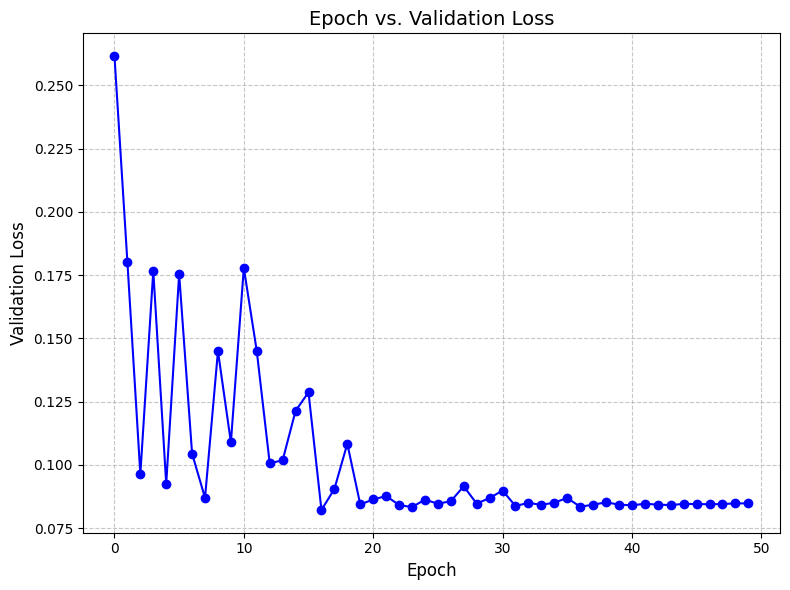

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = r"/content/drive/MyDrive/dip_project/log/final_model/version_2/metrics.csv"
df = pd.read_csv(csv_path)

df_val = df.dropna(subset=["val_loss"])

epoch_loss = df_val.groupby("epoch")["val_loss"].last().reset_index()

plt.figure(figsize=(8, 6))
plt.plot(epoch_loss["epoch"], epoch_loss["val_loss"], marker='o', linestyle='-', color='blue')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Validation Loss", fontsize=12)
plt.title("Epoch vs. Validation Loss", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#3. Comparison of Actual vs. Predicted Retreat Area Over Years

   Year  Actual Retreat Area (Yearly) (%)  Predicted Retreat Area (Yearly) (%)
0  2020                          5.027771                             5.168388
1  2021                          4.532993                             5.980154
2  2022                          5.311274                             5.881360
3  2023                          8.271158                             7.929914
4  2024                          5.683827                             5.592300


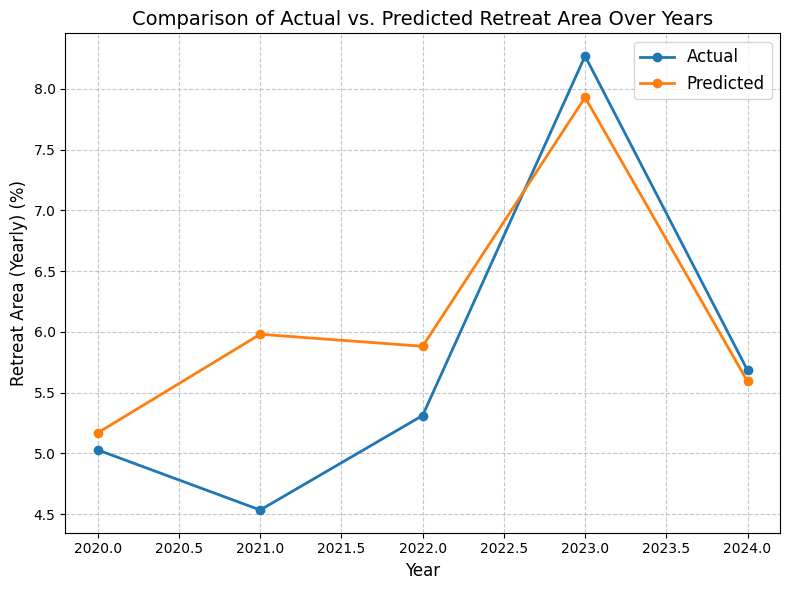

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = r"/content/drive/MyDrive/dip_project/multimodal/multimodal_sea_ice_predictions.csv"
df = pd.read_csv(csv_path)

print(df)

plt.figure(figsize=(8, 6))

plt.plot(df["Year"], df["Actual Retreat Area (Yearly) (%)"], label="Actual", marker="o", linewidth=2)
plt.plot(df["Year"], df["Predicted Retreat Area (Yearly) (%)"], label="Predicted", marker="o", linewidth=2)

plt.xlabel("Year", fontsize=12)
plt.ylabel("Retreat Area (Yearly) (%)", fontsize=12)
plt.title("Comparison of Actual vs. Predicted Retreat Area Over Years", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


   Year  Actual Retreat Area (Yearly) (%)  Predicted Retreat Area (Yearly) (%)
0  2020                          5.027771                             5.168388
1  2021                          4.532993                             5.980154
2  2022                          5.311274                             5.881360
3  2023                          8.271158                             7.929914
4  2024                          5.683827                             5.592300


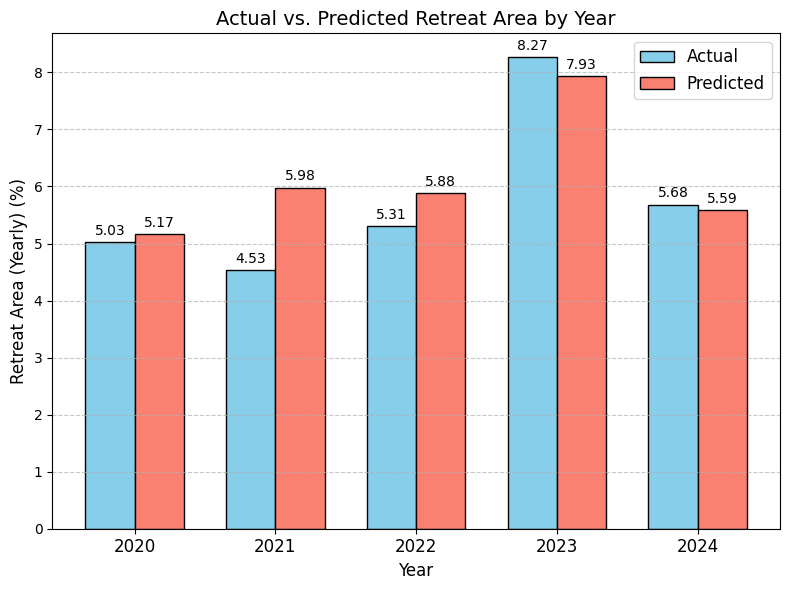

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

csv_path = r"/content/drive/MyDrive/dip_project/multimodal/multimodal_sea_ice_predictions.csv"
df = pd.read_csv(csv_path)
print(df)

years = df["Year"].astype(int)
actual_values = df["Actual Retreat Area (Yearly) (%)"]
predicted_values = df["Predicted Retreat Area (Yearly) (%)"]

x = np.arange(len(years))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))

rects1 = ax.bar(x - width/2, actual_values, width, label='Actual', color='skyblue', edgecolor='black')

rects2 = ax.bar(x + width/2, predicted_values, width, label='Predicted', color='salmon', edgecolor='black')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Retreat Area (Yearly) (%)', fontsize=12)
ax.set_title('Actual vs. Predicted Retreat Area by Year', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(years, fontsize=12)
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

